# 02-03 - Minimum Cuts, Connectivity, and Graph Laplacians

*May 4 2022*

We introduce the graph Laplacian, an important matrix representation of graphs that facilitates graph learning tasks such as community detection, representation learning, or node classification. Here we show that the eigenvalues and eigenvectors of the Laplacian are related to the concept of vertex connectivity and minimal vertex cuts. This the basis for a first graph-theoretic approach to find communities in networks.

In [1]:
import pathpy as pp
import numpy as np
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('default')
sns.set_style("whitegrid")
    
from numpy import linalg as npl
import scipy as sp

We first generate the same undirected toy example as in the previous notebooks:

In [13]:
n = pp.Network(directed=False)
n.add_edge('a', 'b')
n.add_edge('b', 'c')
n.add_edge('a', 'c')
n.add_edge('b', 'd')
n.add_edge('d', 'f')
n.add_edge('d', 'g')
n.add_edge('d', 'e')
n.add_edge('e', 'f')
n.add_edge('f', 'g')
n.plot(edge_color='gray')

## Vertex and Edge Connectivity

As mentioned in the previous notebook, pairs of nodes within the two communities $\{a, b, c\}$ and $\{ d, e, f, g\}$ are "more connected" than pairs of nodes in different communities. In the graph above, this translates to the fact that if we remove either node `b` or node `d` (i.e. one of the two nodes that are incident to the only link connecting the two communities) we break the connection between the two communities, i.e. we obtain a disconnected graph with two connected components.

We call a set of nodes whose removal leaves the remaining graph disconnected a **vertex cut**. The number of nodes in such a vertex cut is called the **vertex cut size**. In the example above, nodes `b` and `d` define two vertex cuts with size one. We further call the minimal size of a vertex cut for a given graph the **vertex connectivity**. Hence, the graph above has a vertex connectivity of one.

So far, we have considered a network either as *connected* (if it contains a single connected component) or *disconnected* (if it contains more than one connected component). We could say that the connectivity was either zero (disconnected) or one (connected), i.e. a binary concept. For connected networks, we did not distinguish how well-connected the network was. We can view *vertex connectivity* as a numerical generalization of this binary concept of *connectivity*. A network with vertex connectivity zero is disconnected, while a network with vertex connectivity larger than zero is connected. The magnitude of the vertex connectivity tells us how well-connected a network is. This can be interpreted as a robustness of the network against the removal of nodes, i.e. a network with larger vertex connectivity is more difficult to "destroy" than a network with small vertex connectivity.

We can algorithmically calculate the minimum size of a vertex cut (and thus the vertex connectivity of a graph) based on a relationship between the minimum cut size and the maximum number of disjoint paths between any pairs of nodes that was first established by Karl Menger. This is the basis to calculate vertex connectivity using max-flow algorithms like that proposed by [Ford and Fulkerson](http://www.cs.yale.edu/homes/lans/readings/routing/ford-max_flow-1956.pdf).

Just like for the calculation of the diameter based on the adjacency matrix, here we discuss an algebraic approach to approximate the size of the minimal vertex cut in a network based on the eigenvalue of the Laplacian matrix. This is the theoretical foundation for a spectral clustering algorithm that uses the eigenvalues and eigenvectors of the Laplacian matrix to detect communities in a network.

The following function computes the Laplacian matrix of an undirected network:

In [3]:
def laplacian(network):
    A = network.adjacency_matrix()
    D = sp.sparse.diags(pp.statistics.degree_sequence(network))
    L = D - A
    return L

For our simple network, we obtain:

In [4]:
L = laplacian(n)
print(L.todense())

[[ 2. -1. -1.  0.  0.  0.  0.]
 [-1.  3. -1. -1.  0.  0.  0.]
 [-1. -1.  2.  0.  0.  0.  0.]
 [ 0. -1.  0.  4. -1. -1. -1.]
 [ 0.  0.  0. -1.  3. -1. -1.]
 [ 0.  0.  0. -1. -1.  2.  0.]
 [ 0.  0.  0. -1. -1.  0.  2.]]


In the lecture, we introduced algebraic connectivity, which is defined as the second-smallest eigenvalue of the Laplacian matrix. Using the `scipy.sparse.linalg` module we can compute the leading eigenvalues of the Laplacian matrix as follows. `SM` stands for smallest magnitude and `k=2` yields the first two eigenvalues in the sorted sequence.

In [5]:
eigenvalues = sp.sparse.linalg.eigs(L, which="SM", k=2, return_eigenvectors=False)
eigenvalues = np.sort(np.absolute(eigenvalues))
print(eigenvalues)

[1.68390150e-17 3.98320868e-01]


Due to the properties of the Laplacian matrix, the smallest eigenvalue is necessarily zero. In the example above, we get a non-zero value due to limited numerical precision. However, we can use the `isclose` function of `numpy` to confirm that this value is numerically zero:

In [6]:
print(np.isclose(0, eigenvalues[0]))

True


The following function returns the algebraic connectivity of an undirected network:

In [7]:
def algebraic_connectivity(network):
    L = laplacian(network)
    w = sp.sparse.linalg.eigs(L, which="SM", k=2, return_eigenvectors=False)
    eigenvalues_sorted = np.sort(np.absolute(w))
    return eigenvalues_sorted[1]

Just like our binary definition of connectivity and the definition of vertex connectivity, the algebraic connectivity of a disconnected network is zero:

In [14]:
n_disconnected = pp.Network(directed=False)
n_disconnected.add_edge('a', 'b')
n_disconnected.add_edge('b', 'c')
n_disconnected.add_edge('a', 'c')
n_disconnected.add_edge('d', 'f')
n_disconnected.add_edge('d', 'g')
n_disconnected.add_edge('d', 'e')
n_disconnected.add_edge('e', 'f')
n_disconnected.add_edge('f', 'g')
n_disconnected.plot(edge_color='gray')

In [9]:
a = algebraic_connectivity(n_disconnected)
print(np.isclose(a, 0))

True


For a connected network, the algebraic connectivity is larger than zero:

In [10]:
a = algebraic_connectivity(n)
print(a)

0.39832086811684553


Just like vertex connectivity, the magnitude of the algebraic connectivity tells us how well-connected a network is, i.e. if we increase the size of the vertex cut, i.e. in our example we add a connection between the two communities, both the vertex connectivity and the algebraic connectivity increase. Here, we add a link from `a` to `c`, which incrases the vertex connectivity by one:

In [15]:
n.add_edge('f', 'c')
n.plot(edge_color='gray')

We find that the algebraic connectivity increases as well:

In [16]:
a = algebraic_connectivity(n)
print(a)

0.8850924585232446


In fact, one can show that the algebraic connectivity $\lambda_2(\mathcal{L}(G))$ of an undirected graph $G$ is bounded above by the vertex connectivity, $c_v(G)$ of that graph, i.e. 

$\lambda_2(\mathcal{L}(G)) \leq c_v(G)$

Let us explore this in a small experiment. For this, we generate a $k$-regular random graph, i.e. a random graph in which all nodes have degree $k$. Since all nodes have degree $k$ the vertex connectivity of such a graph is $k$ (we must at least remove the $k$ neighbors of one node to isolate  this node).

In [18]:
k3 = pp.generators.k_regular_random(k=3, n=20, node_uids=[str(i) for i in range(20)])
k3.plot(edge_color='gray')

We find that the algebraic connectivity increases if we increase $k$ (and the vertex connectivity).

In [19]:
a = algebraic_connectivity(k3)
print(a)

0.39054596436065075


In [22]:
k5 = pp.generators.k_regular_random(k=5, n=20, node_uids=[str(i) for i in range(20)])
k5.plot(edge_color='gray')

In [23]:
a = algebraic_connectivity(k5)
print(a)

2.323418186576298


In [24]:
k7 = pp.generators.k_regular_random(k=7, n=20, node_uids=[str(i) for i in range(20, 40)])
k7.plot(edge_color='gray')

In [25]:
a = algebraic_connectivity(k7)
print(a)

3.885808929505555


Maybe the algebraic connectivity is just related to the degrees of the nodes, and not to the vertex connectivity. To test this, we merge the two graphs above (i.e. the $5$-regular and the $7$-regular random graph) into a single graph with two connected components. We then add one edge between the two components, which yields a graph where all node degrees are identical or - for the two nodes connected by the additional link - larger than in the individual graphs before. If algebraic connectivity just captured node degrees, we would expect that it either remains the same or increases compared to the algebraic connectivity of the individual networks.

In [26]:
n = k5 + k7
n.add_edge('5', '25')
n.plot(edge_color='gray')

This graph now exhibits a small vertex cut of size one, i.e. we can either remove node `25` or node `5` to split it into two connected components. Hence, we have reduced the vertex connectivity. We find that this is reflected by a substantial decrease of algebraic connectivity:

In [27]:
a = algebraic_connectivity(n)
print(a)

0.07369285957156481


We experimentally explore the relationship between vertex connectivity and algebraic connectivity by generating $k$-regular random networks (which have vertex connectivity $k$). We then plot the vertex connectivity (x-axis) against the algebraic connectivity (y-axis). The results are consistent with the fact that vertex connectivity is an upper bound for algebraic connectivity (the blue curve is below the red dashed line).

Text(0, 0.5, 'Algebraic connectivity')

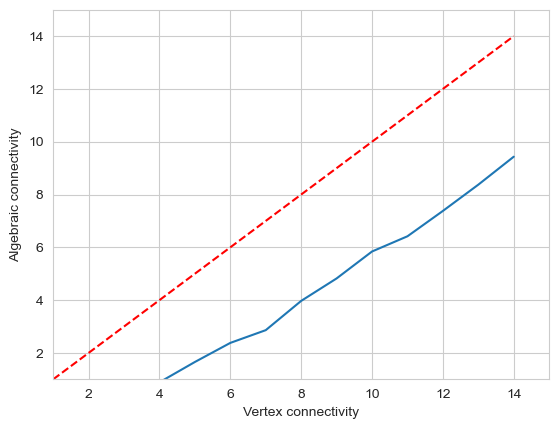

In [28]:
vertex_conn = []
alg_conn = []
for k in range(1, 15):
    x = pp.generators.k_regular_random(k=k, n=30)
    vertex_conn.append(k)
    alg_conn.append(algebraic_connectivity(x))
plt.plot(vertex_conn, vertex_conn, color='red', ls='--')
plt.plot(vertex_conn, alg_conn)
plt.xlim(1, 15)
plt.ylim(1, 15)
plt.xlabel('Vertex connectivity')
plt.ylabel('Algebraic connectivity')

## Normalized edge cuts and graph bisections

The vertex connectivity of a graph focuses on the question how the removal of *nodes* affects the connectivity of a graph. Considering that we are interested in the detection of communities of densely connected nodes, it may appear more natural to consider the question how the removal of edges influences connectivity. This is captured by the concept of an *edge cut*. Let us illustrate this in the example from above:

In [29]:
n = pp.Network(directed=False)
n.add_edge('a', 'b')
n.add_edge('b', 'c')
n.add_edge('a', 'c')
n.add_edge('b', 'd')
n.add_edge('d', 'f')
n.add_edge('d', 'g')
n.add_edge('d', 'e')
n.add_edge('e', 'f')
n.add_edge('f', 'g')
n.plot(edge_color='gray')

Here we can see two communities, i.e. groups of well-connected nodes that are connected by a single link. Specifically, we can define a partition of vertices $V$ into two disjoint sets $S_1 = \{a, b, c\}$ and $S_2 = \{ d, e, f, g\} = V - S_1$ where a single link crosses the two sets. If we cut the single link between those sets the graph becomes disconnected. We call such a partition of nodes an *edge cut* and we call the number of links crossing the sets in the partition the *edge cut size*. We note that the partition of the vertices into the two sets that correspond to our two communities defines a minimal edge cut, i.e. there is no other edge cut with smaller size. 

To make the edge cut size independent from the size of the graph, we often consider a normalized version, that divides the size of the cut by the total degree of nodes in the two partitions. For a given partition $C$, the normalized cut size in a graph is calculated by the following function. Here we assume that the partition is given as a dictionary that assigns 0 or 1 values to nodes, depending on the set to which they are assigned.

In [34]:
def edge_cut_size(n, C):
    crossings = 0
    for e in n.edges:
        if C[e.v.uid] != C[e.w.uid]:
            crossings += 1
    return crossings

In [30]:
def normalized_cut_size(n, C):
    vol_1 = 0
    vol_2 = 0
    crossings = 0
    for e in n.edges:
        if C[e.v.uid] != C[e.w.uid]:
            crossings += 1
    for v in n.nodes.uids:
        if C[v] == 0:
            vol_1 += n.degrees()[v]
        else:
            vol_2 += n.degrees()[v]
    return crossings*(1/vol_1 + 1/vol_2)

let us calculate the normalized edge cut size for the network above, if we partition the vertices along the communities, i.e. here we have a cut with a single edge.

In [35]:
edge_cut_size(n, {'a': 0, 'b': 0, 'c': 0, 'd': 1, 'e': 1, 'f': 1, 'g': 1})

1

In [31]:
normalized_cut_size(n, {'a': 0, 'b': 0, 'c': 0, 'd': 1, 'e': 1, 'f': 1, 'g': 1})

0.23376623376623376

Partitioning nodes such that we place `a` and `c` in one set and all other nodes in the other set increases the cut size, i.e. this is less optimal.

In [36]:
edge_cut_size(n, {'a': 0, 'b': 1, 'c': 0, 'd': 1, 'e': 1, 'f': 1, 'g': 1})

2

In [37]:
normalized_cut_size(n, {'a': 0, 'b': 1, 'c': 0, 'd': 1, 'e': 1, 'f': 1, 'g': 1})

0.6428571428571428

This naturally leads to the question whether we can calculate minimal normalized edge cuts to detect communities in a graph. The problem is that finding an edge cut with minimal normalized cut size is, unfortunately [NP hard](https://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf).

However, this problem is NP hard if we assume that we are interested in a partition given by a vector, where integer vector entries are indicator functions that map nodes to the cut sets. If we relax this condition to a problem where we are interested in a real-valued vector, we can give a polynomial time algorithm based on the Laplacian matrix. While we are skipping the mathematical proof (see future exercise) here, it can be shown that the entries of the second-smallest eigenvector of the Laplacian matrix provide an (heuristic) solution to the problem of finding an edge cut with minimal size.

The eigenvector corresponding to the algebraic connectivity can be computed as follows:

In [38]:
def fiedler_vector(L):
    w, v = sp.linalg.eig(L.todense(), right=False, left=True)
    return v[:, np.argsort(np.absolute(w))][:, 1]

If we inspect the entries of this vector, we find that we can bisect the nodes based on the sign of the entries. We further see that nodes `a`, `b` and `c` are placed in one set (nodes with negative sign) while the other nodes are placed in the other set (nodes with positive sign).

In [39]:
print(n.nodes.index)
print(fiedler_vector(laplacian(n)))

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'f': 4, 'g': 5, 'e': 6}
[-0.4928865  -0.29655952 -0.4928865   0.21422028  0.35603741  0.35603741
  0.35603741]


In many works, rather than using the definition of the Laplacian matrix above, a normalized version of the Laplacian matrix is used that is defined as follows (see e.g. [Shi and Malik, 2000](https://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf)):

$L_{norm} := D^{-\frac{1}{2}} \mathcal{L} D^{-\frac{1}{2}} = D^{-\frac{1}{2}}(D-A)D^{-\frac{1}{2}} = (D^{-\frac{1}{2}}D-D^{-\frac{1}{2}}A)D^{-\frac{1}{2}} = D^{-\frac{1}{2}}DD^{-\frac{1}{2}}-D^{-\frac{1}{2}}AD^{-\frac{1}{2}} = I - D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$ "

This definition has the benefit that it normalizes matrix entries based on the node degrees. Hence, in networks with highly heterogeneous degrees we avoid the issue that nodes with high degree strongly influence the eigenvalues and eigenvectors of the Laplacian.

The following function computes the normalized Laplacian matrix:

In [40]:
def normalized_laplacian(network: pp.Network):
    I = sp.sparse.identity(network.number_of_nodes())
    A = network.adjacency_matrix()
    D_inv_sqrt = sp.sparse.diags(pp.statistics.degree_sequence(network)).power(-0.5)
    L = I- D_inv_sqrt * A * D_inv_sqrt
    return L

In [41]:
normalized_laplacian(n).todense()

matrix([[ 1.        , -0.40824829, -0.5       ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [-0.40824829,  1.        , -0.40824829, -0.28867513,  0.        ,
          0.        ,  0.        ],
        [-0.5       , -0.40824829,  1.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.28867513,  0.        ,  1.        , -0.28867513,
         -0.35355339, -0.35355339],
        [ 0.        ,  0.        ,  0.        , -0.28867513,  1.        ,
         -0.40824829, -0.40824829],
        [ 0.        ,  0.        ,  0.        , -0.35355339, -0.40824829,
          1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , -0.35355339, -0.40824829,
          0.        ,  1.        ]])

For this normalized version of the Laplacian matrix, we again find that the signs of the entries in the Fiedler vector provide us with a minimal edge cut that separates the nodes in the two communities of the graph.

In [42]:
fiedler_vector(normalized_laplacian(n))

array([ 0.47975842,  0.384391  ,  0.47975842, -0.25562618, -0.384391  ,
       -0.29900342, -0.29900342])

Many more could (and will) be said about the interpretation of the graph Laplacian, which is a simple matrix representation with very complex interpretations and applications. 

In our course *Statistical Network Analysis* we have motivated the Laplacian from the perspective of dynamical processes, showing that it can be understood as a discrete generalization of the continuous-time Laplacian differential operator in Euclidean space to arbitrary graph topologies (see Lecture L12 in script on WueCampus). In this view, the eigenvalues of the Laplacian can be interpreted as scalar values that determine the speed of a diffusion process, while the eigenvectors determine the independent *modes* from which we can compose the temporal dynamics of the process.

Complementing this interpretation, here we have taken a graph-theoretic perspective that interprets the algebraic connectivity and the Fiedler vector of the Laplacian matrix in terms of minimum vertex or edge cuts.